In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, Activation
from tensorflow.keras.datasets import cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Vamos a cargar nuestros datos

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


Podemos ver que el dataset tiene multiples imagenes de multiples elementos como vehiculos, animales, etc

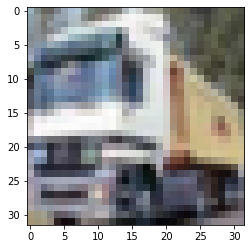

In [4]:
plt.imshow(x_train[1])

Vamos a hacer una limpieza de datos comenzando por reducir la dimension de las imagenes. Sabemos que las matrices van de 0 a 255, entonces vamos a volver los numeros de 0 a 1 asi:

In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Vamos a reducir tambien o reestructurar los arreglos para los labels.

In [6]:
num_clases = len(np.unique(y_train)) #Hay 10 posibles numeros aca
y_train = to_categorical(y_train, num_clases) #To categorical vuelve los valores de clasificacion en un binario
y_test = to_categorical(y_test, num_clases) #Arreglo de 10 posibilidades donde marca el 1 donde esta la clase

Vamos a dividir nuestro set de entrenamiento en set de validacion, entrenamiento y test

In [7]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape:', x_train.shape)

print('train:', x_train.shape[0]) #Usara 45000 imagenes
print('val:', x_valid.shape[0]) #Usara 5000 imagenes
print('test:', x_test.shape[0]) #Usara 10000 imagenes

x_train shape: (45000, 32, 32, 3)
train: 45000
val: 5000
test: 10000
